In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# Read file
path = '/Users/rodrigovillatoro/Documents/Harbour.Space/07_ml_1/data/ConfLongDemo_JSI.txt'
names = ['name', 'tag', 'timestamp', 'date', 'x', 'y', 'z', 'activity']
date_parser = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S:%f')
df = pd.read_csv(path, names=names, header=None, parse_dates=[3], date_parser=date_parser)

In [3]:
df.head()

,name,tag,timestamp,date,x,y,z,activity
0,A01,010-000-024-033,633790226051280329,2009-05-27 14:03:25.127,4.062931,1.892434,0.507425,walking
1,A01,020-000-033-111,633790226051820913,2009-05-27 14:03:25.183,4.291954,1.781140,1.344495,walking
2,A01,020-000-032-221,633790226052091205,2009-05-27 14:03:25.210,4.359101,1.826456,0.968821,walking
3,A01,010-000-024-033,633790226052361498,2009-05-27 14:03:25.237,4.087835,1.879999,0.466983,walking
4,A01,010-000-030-096,633790226052631792,2009-05-27 14:03:25.263,4.324462,2.072460,0.488065,walking


In [4]:
names = df['name'].unique()
tags = df['tag'].unique()

In [5]:
df = df.sort_values(by=['name', 'tag', 'date'])

In [6]:
df.shape

(164860, 8)

## Some exploratory analysis

In [7]:
df['name'].value_counts()

E03    9112
E01    9098
E05    8893
E04    8514
E02    8075
D01    7463
B01    6647
D03    6562
C05    6490
D02    6416
C04    6323
C01    6297
C03    6267
C02    6216
B02    6091
D05    6057
B05    5953
A01    5830
B04    5789
A02    5691
B03    5670
D04    5454
A04    5402
A03    5326
A05    5224
Name: name, dtype: int64

In [8]:
# Work with only A01
a01 = df[df['name'] == 'A01'].copy()

In [9]:
# Work with ANKLE_LEFT only  
a01_t = a01[a01['tag'] == '010-000-024-033'].copy()

In [10]:
print(a01.shape)
print(a01_t.shape)

(5830, 8)
(1672, 8)


In [11]:
a01_t['dx'] = a01_t['x'].diff(1)

In [12]:
a01_t.head()

,name,tag,timestamp,date,x,y,z,activity,dx
0,A01,010-000-024-033,633790226051280329,2009-05-27 14:03:25.127,4.062931,1.892434,0.507425,walking,NaN
3,A01,010-000-024-033,633790226052361498,2009-05-27 14:03:25.237,4.087835,1.879999,0.466983,walking,0.024904
7,A01,010-000-024-033,633790226053442677,2009-05-27 14:03:25.343,3.958496,1.703563,0.511041,walking,-0.129339
9,A01,010-000-024-033,633790226054523854,2009-05-27 14:03:25.453,4.016991,1.734065,0.193167,walking,0.058495
13,A01,010-000-024-033,633790226055605037,2009-05-27 14:03:25.560,3.748375,2.073422,0.254482,walking,-0.268616


In [13]:
time_delta = a01_t['date'].diff(1)

In [14]:
a01_t.head()

,name,tag,timestamp,date,x,y,z,activity,dx
0,A01,010-000-024-033,633790226051280329,2009-05-27 14:03:25.127,4.062931,1.892434,0.507425,walking,NaN
3,A01,010-000-024-033,633790226052361498,2009-05-27 14:03:25.237,4.087835,1.879999,0.466983,walking,0.024904
7,A01,010-000-024-033,633790226053442677,2009-05-27 14:03:25.343,3.958496,1.703563,0.511041,walking,-0.129339
9,A01,010-000-024-033,633790226054523854,2009-05-27 14:03:25.453,4.016991,1.734065,0.193167,walking,0.058495
13,A01,010-000-024-033,633790226055605037,2009-05-27 14:03:25.560,3.748375,2.073422,0.254482,walking,-0.268616


In [15]:
(100000 * a01_t['dx'][1:]) / time_delta[1:].dt.microseconds

3       0.022640
7      -0.122018
9       0.053177
13     -0.251043
15      0.065927
19      0.204311
21     -0.008922
24      0.002771
27     -0.203635
30      0.191209
33     -0.024687
37     -0.186140
40      0.227731
44     -0.013200
47     -0.199849
50     -0.012019
53      0.151588
57      0.138696
60     -0.084903
66     -0.020413
70     -0.045245
73      0.044888
77     -0.067450
80      0.075164
84     -0.051436
87      0.050727
91      0.014518
94     -0.032484
98      0.069898
101    -0.091208
          ...   
5732    0.023222
5735    0.080640
5739   -0.012530
5742    0.204929
5745   -0.017343
5748    0.118711
5752   -0.041136
5753   -0.052848
5756    0.009911
5759    0.043491
5763   -0.092891
5765    0.022627
5769    0.178780
5772   -0.208443
5776   -0.029153
5779    0.077400
5782    0.057867
5785    0.118575
5789   -0.281602
5792    0.046155
5796   -0.057420
5799    0.189363
5803    0.363637
5806    0.203655
5810    0.128523
5813    0.085350
5817   -0.208473
5820    0.0395

In [16]:
unique_deltas_in_seconds = set()
for name in names:
    temp_df1 = df[df['name'] == name].copy()
    for tag in tags:
        time_delta = temp_df1[temp_df1['tag'] == tag]['date'].diff(1)
        for i in range(1, len(time_delta)):
            unique_deltas_in_seconds.add((time_delta.iloc[i].seconds, name))

In [17]:
unique_deltas_in_seconds

{(0, 'A01'),
 (0, 'A02'),
 (0, 'A03'),
 (0, 'A04'),
 (0, 'A05'),
 (0, 'B01'),
 (0, 'B02'),
 (0, 'B03'),
 (0, 'B04'),
 (0, 'B05'),
 (0, 'C01'),
 (0, 'C02'),
 (0, 'C03'),
 (0, 'C04'),
 (0, 'C05'),
 (0, 'D01'),
 (0, 'D02'),
 (0, 'D03'),
 (0, 'D04'),
 (0, 'D05'),
 (0, 'E01'),
 (0, 'E02'),
 (0, 'E03'),
 (0, 'E04'),
 (0, 'E05'),
 (1, 'A02'),
 (1, 'A03'),
 (1, 'A05'),
 (1, 'B02'),
 (1, 'B03'),
 (1, 'B04'),
 (1, 'B05'),
 (1, 'C02'),
 (1, 'C03'),
 (1, 'C04'),
 (1, 'C05'),
 (1, 'D01'),
 (1, 'D03'),
 (1, 'D04'),
 (1, 'D05'),
 (1, 'E01'),
 (1, 'E02'),
 (1, 'E03'),
 (1, 'E04'),
 (1, 'E05'),
 (2, 'A05'),
 (2, 'B04'),
 (2, 'D04'),
 (2, 'E04'),
 (3, 'B03'),
 (3, 'C01'),
 (3, 'D04'),
 (4, 'B03')}

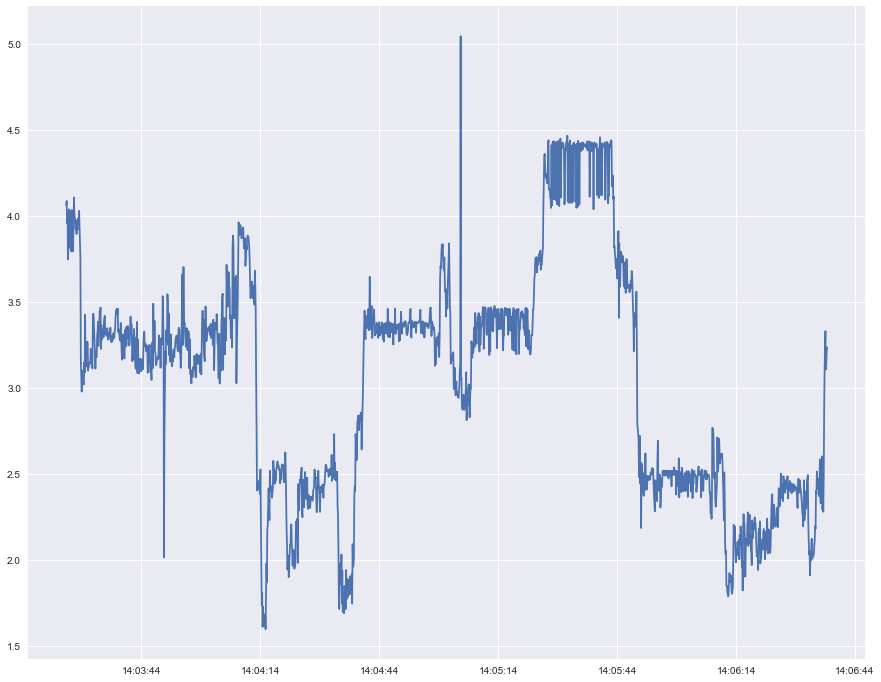

In [18]:
plt.figure(figsize=(15, 12))
plt.plot(a01_t['date'], a01_t['x'])
plt.show()

## Calculate the change in X, Y, Z coordinates for each person

In [19]:
data_frames = []
for name in names:
    temp_df1 = df[df['name'] == name].copy()
    for tag in tags:
        temp_df2 = temp_df1[temp_df1['tag'] == tag].copy()
        time_delta = temp_df2['date'].diff(1)
        temp_df2['dx'] = (100000 * temp_df2['x'].diff(1)[1:]) / time_delta[1:].dt.microseconds
        temp_df2['dy'] = (100000 * temp_df2['y'].diff(1)[1:]) / time_delta[1:].dt.microseconds
        temp_df2['dz'] = (100000 * temp_df2['z'].diff(1)[1:]) / time_delta[1:].dt.microseconds
        data_frames.append(temp_df2)

In [20]:
# Concatenate the all the data_frames and drop NA's
new_df = pd.concat(data_frames)
new_df = new_df.dropna()

In [21]:
new_df.shape

(164760, 11)

In [22]:
tags = pd.get_dummies(df['tag'], prefix='tag')
names = pd.get_dummies(df['name'], prefix='name')

In [23]:
new_df = new_df.join([tags, names])

In [24]:
new_df.shape

(164760, 40)

In [25]:
new_df.head()

,name,tag,timestamp,date,x,y,z,activity,dx,dy,...,name_D01,name_D02,name_D03,name_D04,name_D05,name_E01,name_E02,name_E03,name_E04,name_E05
3,A01,010-000-024-033,633790226052361498,2009-05-27 14:03:25.237,4.087835,1.879999,0.466983,walking,0.022640,-0.011305,...,0,0,0,0,0,0,0,0,0,0
7,A01,010-000-024-033,633790226053442677,2009-05-27 14:03:25.343,3.958496,1.703563,0.511041,walking,-0.122018,-0.166449,...,0,0,0,0,0,0,0,0,0,0
9,A01,010-000-024-033,633790226054523854,2009-05-27 14:03:25.453,4.016991,1.734065,0.193167,walking,0.053177,0.027729,...,0,0,0,0,0,0,0,0,0,0
13,A01,010-000-024-033,633790226055605037,2009-05-27 14:03:25.560,3.748375,2.073422,0.254482,walking,-0.251043,0.317157,...,0,0,0,0,0,0,0,0,0,0
15,A01,010-000-024-033,633790226056686205,2009-05-27 14:03:25.670,3.820894,2.049378,0.055377,walking,0.065927,-0.021859,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Rremove values set to inf and -inf (only one value)
new_df = new_df.replace([np.inf, -np.inf], np.nan).dropna()
new_df.shape

(164759, 40)

In [27]:
std_scale = StandardScaler().fit_transform(new_df[['x', 'y', 'z', 'dx', 'dy', 'dz']])

In [28]:
new_df[['x', 'y', 'z', 'dx', 'dy', 'dz']] = std_scale

In [29]:
new_df.head()

,name,tag,timestamp,date,x,y,z,activity,dx,dy,...,name_D01,name_D02,name_D03,name_D04,name_D05,name_E01,name_E02,name_E03,name_E04,name_E05
3,A01,010-000-024-033,633790226052361498,2009-05-27 14:03:25.237,1.394024,0.386435,0.129029,walking,0.099538,-0.064324,...,0,0,0,0,0,0,0,0,0,0
7,A01,010-000-024-033,633790226053442677,2009-05-27 14:03:25.343,1.252782,0.014045,0.245298,walking,-0.537727,-0.934796,...,0,0,0,0,0,0,0,0,0,0
9,A01,010-000-024-033,633790226054523854,2009-05-27 14:03:25.453,1.316660,0.078424,-0.593577,walking,0.234061,0.154687,...,0,0,0,0,0,0,0,0,0,0
13,A01,010-000-024-033,633790226055605037,2009-05-27 14:03:25.560,1.023324,0.794681,-0.431766,walking,-1.106121,1.778590,...,0,0,0,0,0,0,0,0,0,0
15,A01,010-000-024-033,633790226056686205,2009-05-27 14:03:25.670,1.102517,0.743932,-0.957206,walking,0.290228,-0.123537,...,0,0,0,0,0,0,0,0,0,0


## Some more exploratory analysis now that I added new features

In [30]:
a01 = new_df[new_df['name'] == 'A01']
a01 = a01[a01['tag'] == '010-000-024-033']
a01.head()

,name,tag,timestamp,date,x,y,z,activity,dx,dy,...,name_D01,name_D02,name_D03,name_D04,name_D05,name_E01,name_E02,name_E03,name_E04,name_E05
3,A01,010-000-024-033,633790226052361498,2009-05-27 14:03:25.237,1.394024,0.386435,0.129029,walking,0.099538,-0.064324,...,0,0,0,0,0,0,0,0,0,0
7,A01,010-000-024-033,633790226053442677,2009-05-27 14:03:25.343,1.252782,0.014045,0.245298,walking,-0.537727,-0.934796,...,0,0,0,0,0,0,0,0,0,0
9,A01,010-000-024-033,633790226054523854,2009-05-27 14:03:25.453,1.316660,0.078424,-0.593577,walking,0.234061,0.154687,...,0,0,0,0,0,0,0,0,0,0
13,A01,010-000-024-033,633790226055605037,2009-05-27 14:03:25.560,1.023324,0.794681,-0.431766,walking,-1.106121,1.778590,...,0,0,0,0,0,0,0,0,0,0
15,A01,010-000-024-033,633790226056686205,2009-05-27 14:03:25.670,1.102517,0.743932,-0.957206,walking,0.290228,-0.123537,...,0,0,0,0,0,0,0,0,0,0


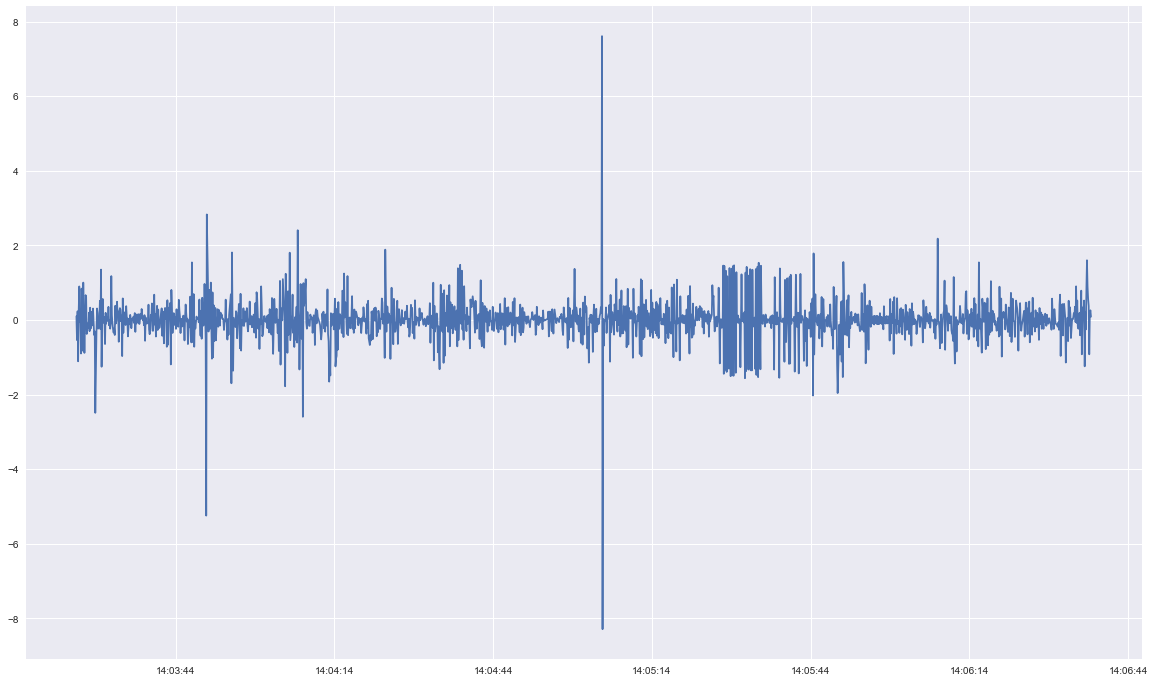

In [31]:
plt.figure(figsize=(20, 12))
plt.plot(a01['date'], a01['dx'])
plt.show()

## Drop Columns that will not be used in the classification

In [32]:
y = new_df['activity']
categories = y.astype('category')
y = categories.cat.codes

In [33]:
X = new_df.drop(['activity', 'date', 'timestamp', 'tag', 'name'], axis=1)

In [34]:
X.columns

Index(['x', 'y', 'z', 'dx', 'dy', 'dz', 'tag_010-000-024-033',
       'tag_010-000-030-096', 'tag_020-000-032-221', 'tag_020-000-033-111',
       'name_A01', 'name_A02', 'name_A03', 'name_A04', 'name_A05', 'name_B01',
       'name_B02', 'name_B03', 'name_B04', 'name_B05', 'name_C01', 'name_C02',
       'name_C03', 'name_C04', 'name_C05', 'name_D01', 'name_D02', 'name_D03',
       'name_D04', 'name_D05', 'name_E01', 'name_E02', 'name_E03', 'name_E04',
       'name_E05'],
      dtype='object')

In [35]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Train Logistic Regression

In [36]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [37]:
clf.score(X_test, y_test)

0.40660354454964798

In [38]:
cm = confusion_matrix(y_test, predictions)
print('Confussion Matrix:')
print(cm)

Confussion Matrix:
[[    0   380     0     0   180     0    10     0     0     0   176]
 [    1 10961     0   233   926     0   206     0     0     0  1303]
 [    0  1082     0    19    14     0     0     0     0     0   390]
 [    0   851     0   215    43     0     0     0     0     0   163]
 [    0  3056     0    10  1354     0     3     0     0     0  2380]
 [    0   286     0     1    25     0     0     0     0     0   128]
 [    0  2176     0     0   348     0   308     0     0     0    75]
 [    0  3516     0    92   228     0    38     0     0     0   804]
 [    0   237     0     0    10     0     0     0     0     0   101]
 [    0   682     0     0    20     0     2     0     0     0    32]
 [    0  3753     0    92   364     0     6     0     0     0  3910]]


In [51]:
categories.cat.categories

Index(['falling', 'lying', 'lying down', 'on all fours', 'sitting',
       'sitting down', 'sitting on the ground', 'standing up from lying',
       'standing up from sitting', 'standing up from sitting on the ground',
       'walking'],
      dtype='object')

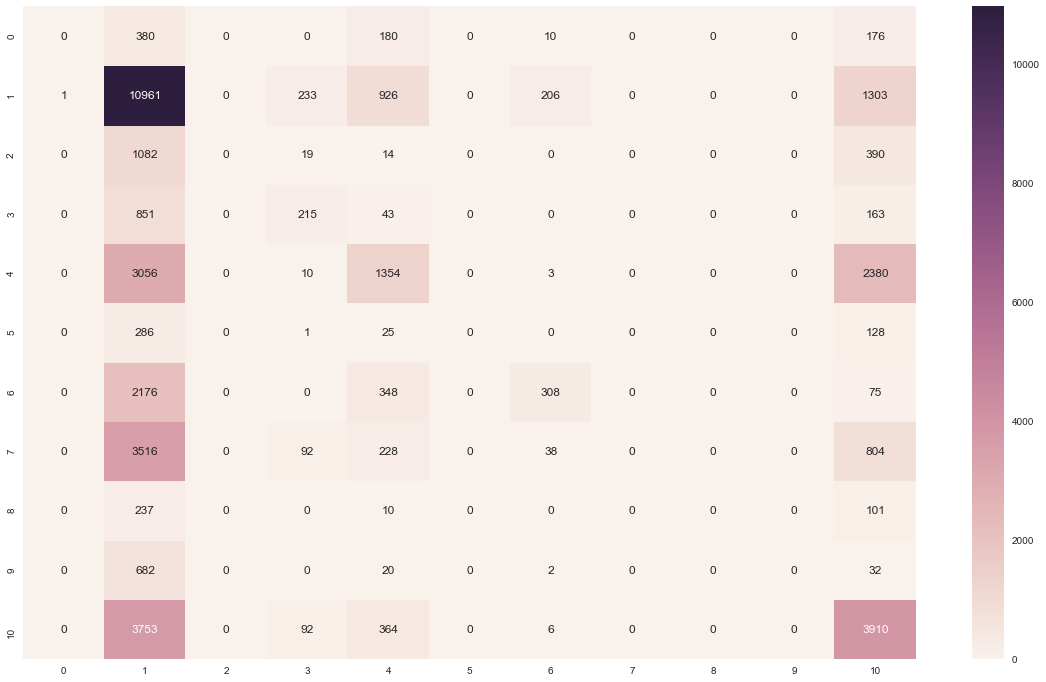

In [39]:
plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

## GaussianNB

In [40]:
clf = GaussianNB()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
clf.score(X_test, y_test)

0.18293275066763778

## Nearest Neighbors

In [41]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
clf.score(X_test, y_test)

0.73005583879582425

In [42]:
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[  132   231     0     7   123     2    58    56     0     4   133]
 [   54 12679    67   126   223     5    51   271     3    12   139]
 [    6   539   316   113    64     1     1   226     4     0   235]
 [    3   318    56   639    44     5     4   109     3     4    87]
 [   32   253    15    21  6108    33    48    54    20     4   215]
 [    2    29    12     5   219    34     6    18    11     0   104]
 [   10    45     0     1    53     0  2749    24     0    13    12]
 [   72  1442   280   150   281    10   120  1685     4    53   581]
 [    0    12     5     6   164    13     3    14    44     2    85]
 [   11    99     2     7    59     5   162    83     2   181   125]
 [   69   593   208    88   883    26    56   599    29    70  5504]]


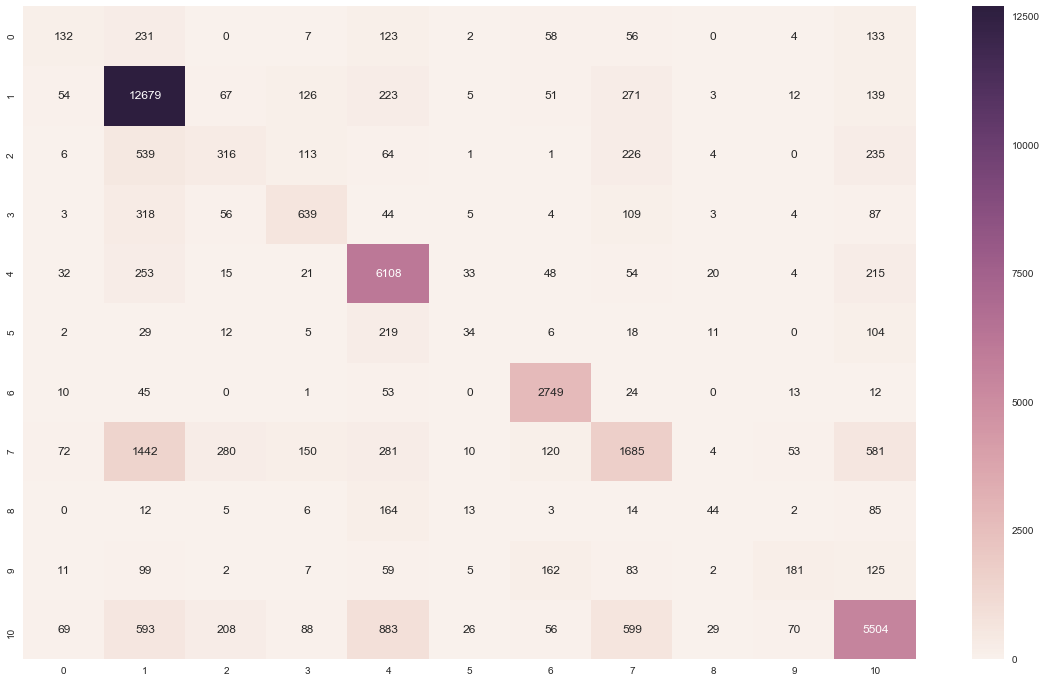

In [43]:
plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

## SVM only for A01

In [44]:
y_a01 = a01['activity']
y_a01 = y_a01.astype('category').cat.codes

In [45]:
X_a01 = a01.drop(['activity', 'date', 'timestamp', 'tag', 'name'], axis=1)

In [46]:
X_a01.columns

Index(['x', 'y', 'z', 'dx', 'dy', 'dz', 'tag_010-000-024-033',
       'tag_010-000-030-096', 'tag_020-000-032-221', 'tag_020-000-033-111',
       'name_A01', 'name_A02', 'name_A03', 'name_A04', 'name_A05', 'name_B01',
       'name_B02', 'name_B03', 'name_B04', 'name_B05', 'name_C01', 'name_C02',
       'name_C03', 'name_C04', 'name_C05', 'name_D01', 'name_D02', 'name_D03',
       'name_D04', 'name_D05', 'name_E01', 'name_E02', 'name_E03', 'name_E04',
       'name_E05'],
      dtype='object')

In [47]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_a01, y_a01)

In [48]:
clf = SVC()
clf.fit(X1_train, y1_train)
predictions = clf.predict(X1_test)
clf.score(X1_test, y1_test)

0.5143540669856459

In [49]:
cm = confusion_matrix(y1_test, predictions)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[  0   5   0   0   1   0   1   0   0   0   0]
 [  0 154   0   0   0   0   0   0   0   0   0]
 [  0   9   0   0   0   0   0   0   0   0   0]
 [  0  26   0   0   0   0   0   0   0   0   0]
 [  0  43   0   0  16   0   0   0   0   0   6]
 [  0   1   0   0   2   0   0   0   0   0   7]
 [  0   0   0   0   0   0  31   0   0   0   0]
 [  0  30   0   0   6   0   3   0   0   0   2]
 [  0   1   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   2   0   0   0   0   0   4]
 [  0  39   0   0  14   0   0   0   0   0  14]]


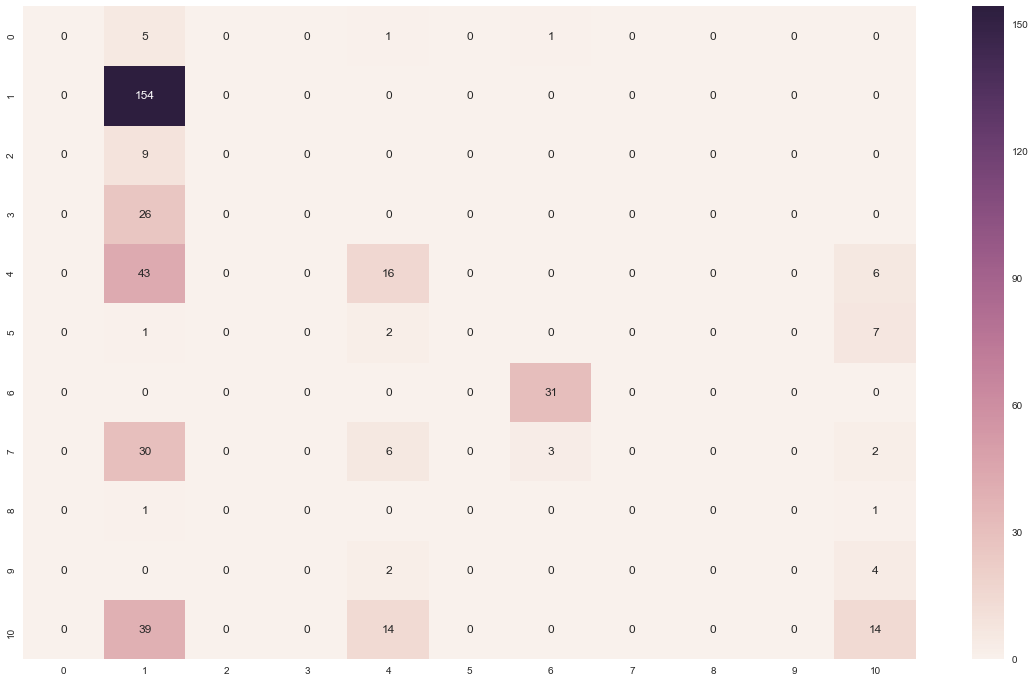

In [50]:
plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True, fmt='g')
plt.show()